<img src="../images/tinap.png" style="float: left; margin: 15px; height: 50px">

# Tina's Project - Ames House Sales Price Prediction

## 01. EDA and Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

### Data Preview

In [3]:
df_train.shape

(2051, 81)

In [4]:
df_test.shape

(878, 80)

### Column Types

In [5]:
df_train.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [6]:
# Numerical columns
num_cols = df_train.select_dtypes(exclude = ['O']).columns.tolist()
len(num_cols)

39

In [7]:
# Categorical columns
cat_cols = df_train.select_dtypes(include = ['O']).columns.tolist()
len(cat_cols)

42

### EDA - Numerical Columns

#### Correlation

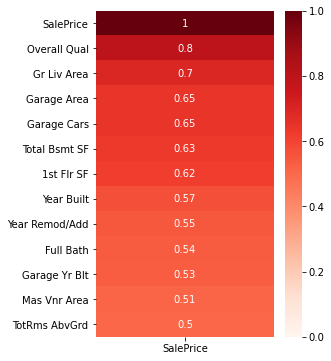

In [8]:
# Correlation x with y
R = df_train.corr()
R_high = R[abs(R['SalePrice'])>=0.5]

plt.figure(figsize = (4,6))
sns.heatmap(R_high[['SalePrice']].sort_values(by = 'SalePrice', ascending = False), 
            annot = True, vmin = 0, vmax = 1, cmap = 'Reds');

> There are 12 numerical variables have over 0.5 correlation with the target variable (`SalePrice`):
>* `Overall Qual`, `Gr Liv Area`, `Garage Area`, `Garage Cars`, `Total Bsmt SF`, `1st Flr SF`, `Year Built`, `Year Remod/Add`, `Full Bath`, `Garage Yr Blt`, `Mas Vnr Area`, and `TotRms AbvGrd`.

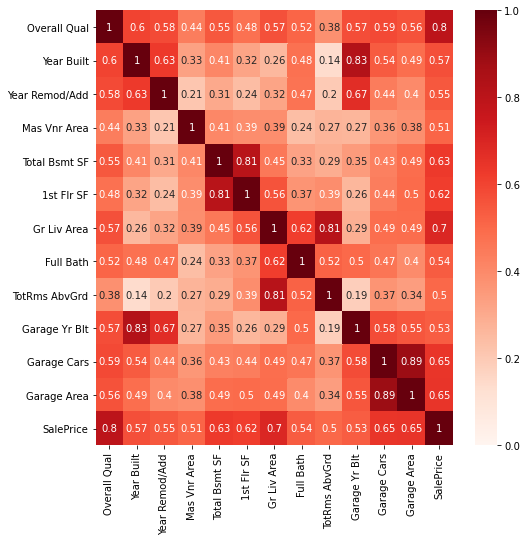

In [9]:
# Correlation x with x
plt.figure(figsize = (8,8))
sns.heatmap(df_train[R_high.index.tolist()].corr(), annot = True, vmin = 0, vmax = 1, cmap = 'Reds');

> In these high correlation variables, there are a few variables have high correlation with each other, such as:
>* `Garage Area` v.s `Garage Cars`
>* `Garage Yr Blt` v.s `Year Built`
>* `TotRms AbvGrd` v.s `Gr Liv Area`
>* `1st Flr SF` v.s `Total Bsmt SF`

> A high correlation between x features will have a negative impact on our model prediction. Thus, I will remove the variable with a lower correlation with the target variable in each pair above.
>* `Garage Cars`, `Garage Yr Blt`, `TotRms AbvGrd`, and `1st Flr SF`

In [10]:
sel_num_col = set(R_high.index) - {'Garage Cars', 'Garage Yr Blt', 'TotRms AbvGrd', '1st Flr SF', 'SalePrice'}
sel_num_col = list(sel_num_col)

In [11]:
df_train[sel_num_col].describe()

,Gr Liv Area,Year Built,Mas Vnr Area,Overall Qual,Garage Area,Full Bath,Total Bsmt SF,Year Remod/Add
count,2051.000000,2051.000000,2029.000000,2051.000000,2050.000000,2051.000000,2050.000000,2051.000000
mean,1499.330083,1971.708922,99.695909,6.112140,473.671707,1.577279,1057.987805,1984.190151
std,500.447829,30.177889,174.963129,1.426271,215.934561,0.549279,449.410704,21.036250
min,334.000000,1872.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1950.000000
25%,1129.000000,1953.500000,0.000000,5.000000,319.000000,1.000000,793.000000,1964.500000
50%,1444.000000,1974.000000,0.000000,6.000000,480.000000,2.000000,994.500000,1993.000000
75%,1728.500000,2001.000000,161.000000,7.000000,576.000000,2.000000,1318.750000,2004.000000
max,5642.000000,2010.000000,1600.000000,10.000000,1418.000000,4.000000,6110.000000,2010.000000


#### Selected feature 1: `Year Built`

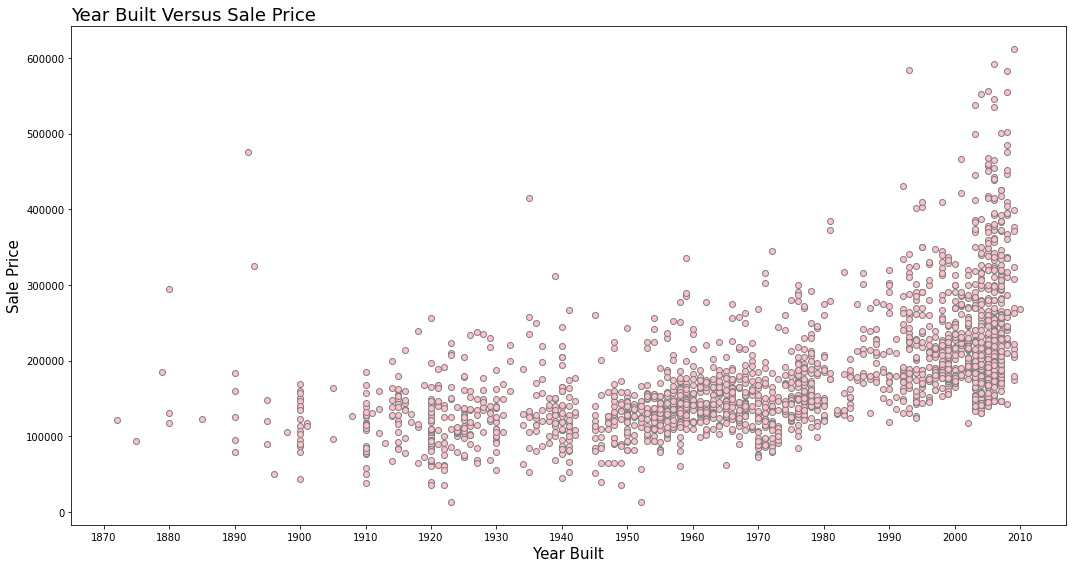

In [65]:
plt.figure(figsize = (15, 8))
plt.scatter(x = df_train['Year Built'], y = df_train['SalePrice'], color = 'pink', edgecolor = 'gray')
plt.xlabel('Year Built', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.xticks(list(range(1870, 2012, 10)))
plt.title('Year Built Versus Sale Price', fontsize = 18, loc = 'left')
plt.tight_layout()
plt.savefig("../images/yrbuilt_sp.png", dpi=100);

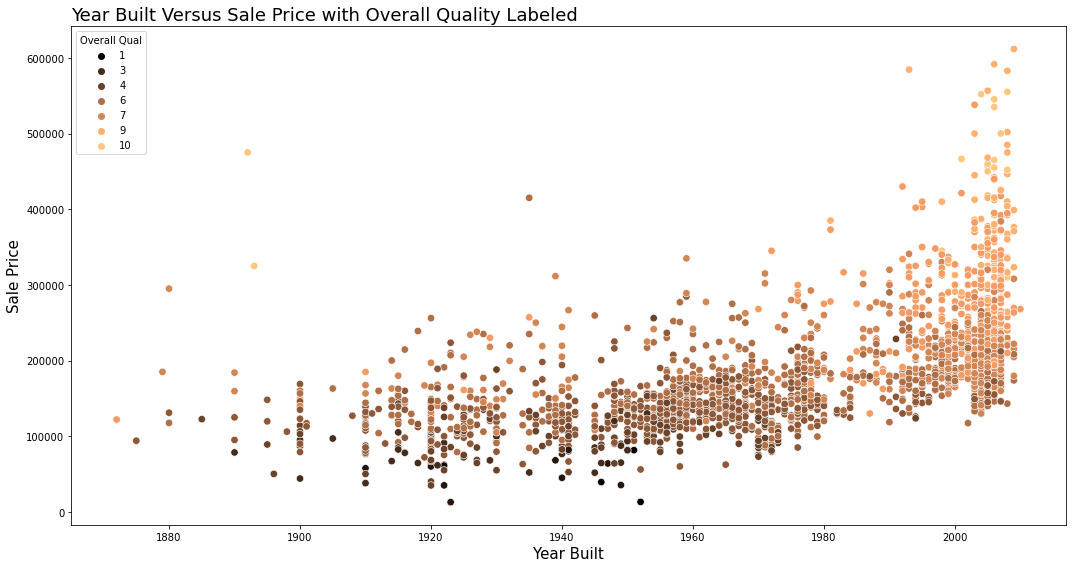

In [75]:
plt.figure(figsize = (15, 8))
sns.scatterplot(data = df_train, x = 'Year Built', y = 'SalePrice',
                hue = 'Overall Qual', palette = 'copper', s = 55)
plt.xlabel('Year Built', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Year Built Versus Sale Price with Overall Quality Labeled', fontsize = 18, loc = 'left')
plt.tight_layout()
plt.savefig("../images/yrbuilt_sp_with_overallqual.png", dpi=100);

**Findings:**
>* The sale price ranges of old houses are smaller than new houses. That is, new houses have a higher chance to sell in a higher price than the old houses.
>* New houses with higher overall quality can be sold at a higher price, whereas new houses with lower quality cannot sold at a higher price.

#### Selected feature 2: `Total Bsmt SF` (total square feet of basement area)

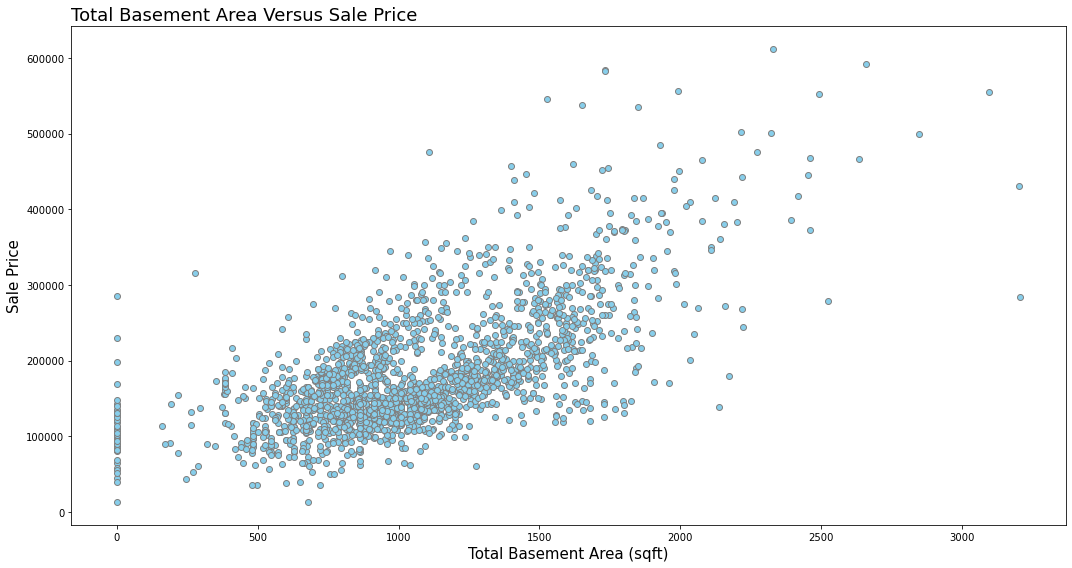

In [66]:
plt.figure(figsize = (15, 8))
plt.scatter(x = df_train['Total Bsmt SF'], y = df_train['SalePrice'], color = 'skyblue', edgecolor = 'gray')
plt.xlabel('Total Basement Area (sqft)', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Total Basement Area Versus Sale Price', fontsize = 18, loc = 'left')
plt.tight_layout()
plt.savefig("../images/ttbsmt_sp.png", dpi=100);

**Findings:**
> * Find 2 outliers which total basement area are over 4000 sqft. --> remove them!
> * Houses with larger basement area can be sold at a higher price.
> * Some houses don't have basement area.

#### Remove the outlier

In [14]:
df_train = df_train[df_train['Total Bsmt SF'] < 4000]
df_train = df_train.reset_index(drop = True)

#### Selected feature 3: `Year Remod/Add`

In [15]:
df_train[df_train['Year Built'] > df_train['Year Remod/Add']][['Year Built', 'Year Remod/Add']]

,Year Built,Year Remod/Add
1002,2002,2001


**Findings:**
> Typically, the year built will be earlier than the year remodel. Therefore, I will drop this piece of observation.

In [16]:
df_train.drop(df_train[df_train['Year Built'] > df_train['Year Remod/Add']].index, axis = 0, inplace = True)
df_train = df_train.reset_index(drop = True)

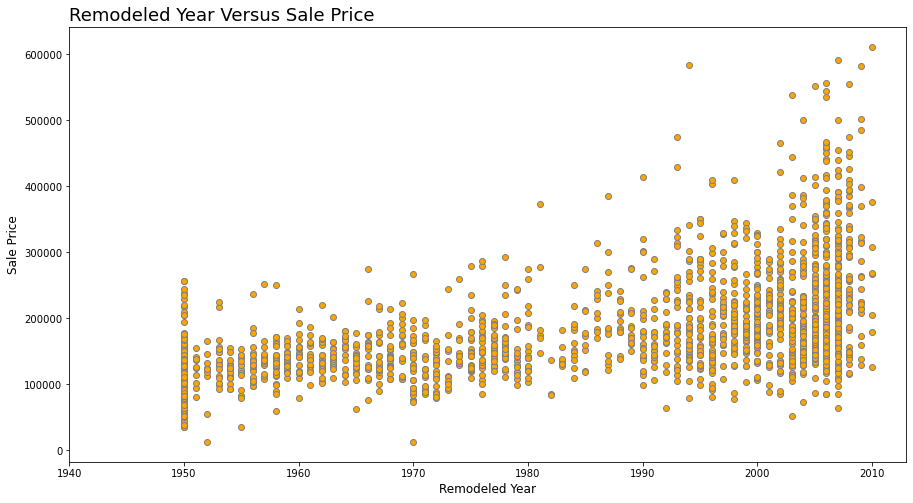

In [17]:
plt.figure(figsize = (15, 8))
plt.scatter(x = df_train['Year Remod/Add'], y = df_train['SalePrice'], color = 'orange', edgecolor = 'gray')
plt.xlabel('Remodeled Year', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.xticks(list(range(1940, 2012, 10)))
plt.title('Remodeled Year Versus Sale Price', fontsize = 18, loc = 'left');

**Findings:**
> * The sale price ranges of houses remodeled earlier are smaller than later ones. That is, newly remodeled houses have a higher chance of selling at a higher price.

#### Selected feature 4: `Gr Liv Area` (Above ground living area square feet)

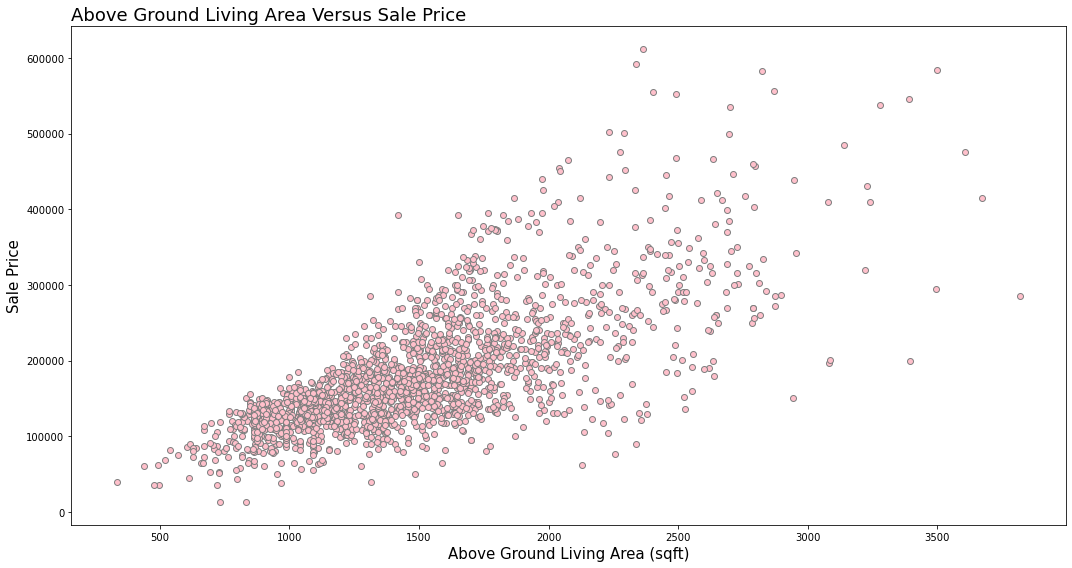

In [67]:
plt.figure(figsize = (15, 8))
plt.scatter(x = df_train['Gr Liv Area'], y = df_train['SalePrice'], color = 'pink', edgecolor = 'gray')
plt.xlabel('Above Ground Living Area (sqft)', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Above Ground Living Area Versus Sale Price', fontsize = 18, loc = 'left')
plt.tight_layout()
plt.savefig("../images/abg_area_sp.png", dpi=100);

**Findings:**
> * Houses with bigger living area above ground can be sold at a higher price.

#### Selected feature 5: `Overall Qual` (Overall material and finish quality. 10: the best / 1: the worst)

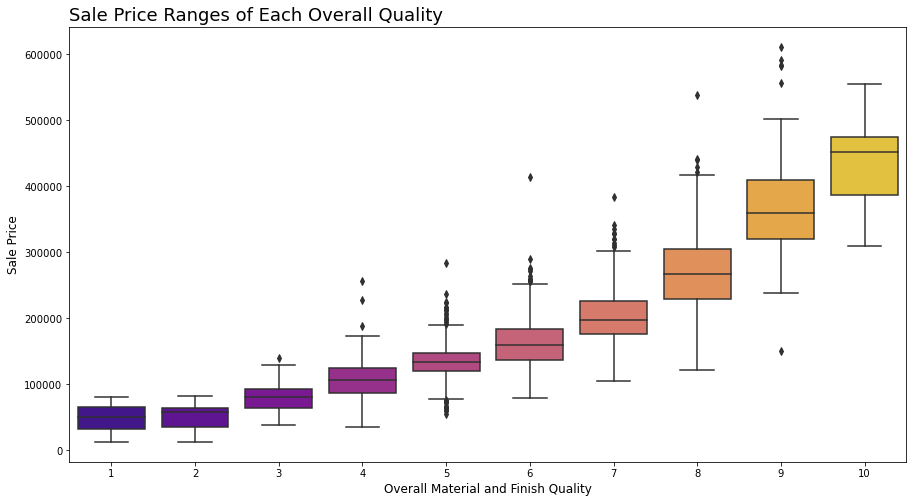

In [19]:
plt.figure(figsize = (15, 8))
sns.boxplot(x = 'Overall Qual', y = 'SalePrice', data = df_train, palette = 'plasma')
plt.xlabel('Overall Material and Finish Quality', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Sale Price Ranges of Each Overall Quality', fontsize = 18, loc = 'left');

**Findings:**
> * Houses with higher overall scores (material and finish quality) can be sold at a higher price.

#### Selected feature 6: `Mas Vnr Area` (Masonry veneer area in square feet)

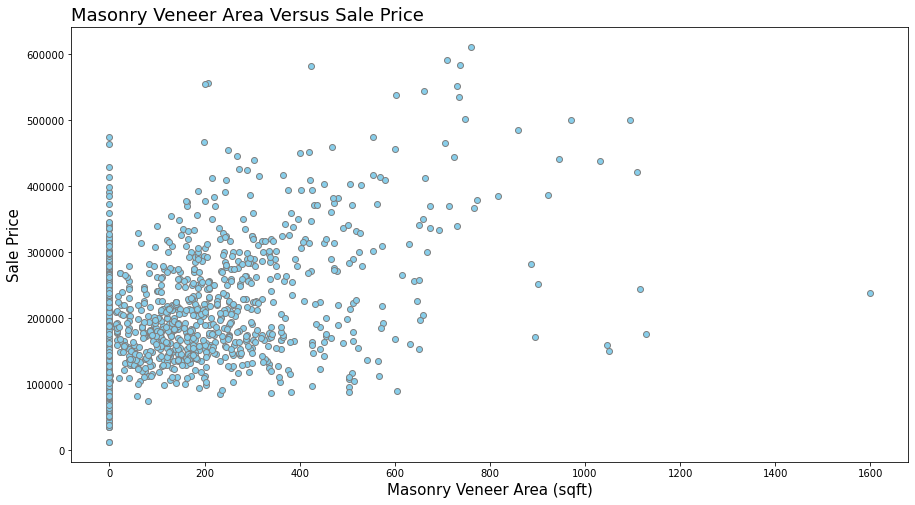

In [68]:
plt.figure(figsize = (15, 8))
plt.scatter(x = df_train['Mas Vnr Area'], y = df_train['SalePrice'], color = 'skyblue', edgecolor = 'gray')
plt.xlabel('Masonry Veneer Area (sqft)', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Masonry Veneer Area Versus Sale Price', fontsize = 18, loc = 'left');

**Findings:**
> * Some houses don't have masonry veneer area.
> * The pattern between `masonry veneer area` and `sale price` is not significant.

#### Create new feature: `has_mas_vnr` (Does this building has masonry veneer?  1: Yes / 0: No)

In [21]:
new_col = []
new_col.append('has_mas_vnr')

In [22]:
df_train['has_mas_vnr'] = np.where(df_train['Mas Vnr Area'] > 0, 1, 0)
df_test['has_mas_vnr'] = np.where(df_test['Mas Vnr Area'] > 0, 1, 0)

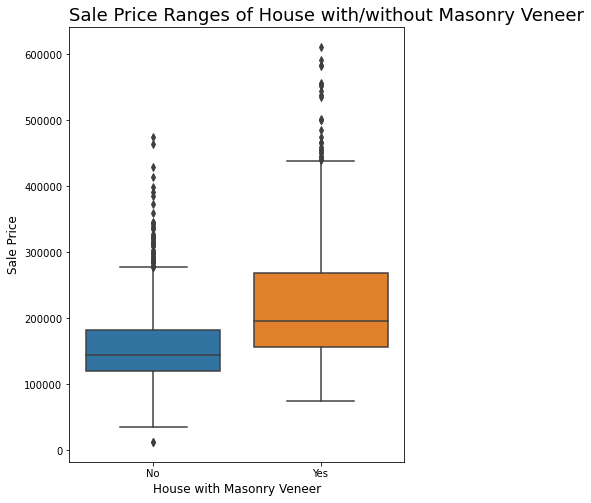

In [23]:
plt.figure(figsize = (6, 8))
sns.boxplot(x = 'has_mas_vnr', y = 'SalePrice', data = df_train)
plt.xlabel('House with Masonry Veneer', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.xticks([0, 1], ['No', 'Yes'])
plt.title('Sale Price Ranges of House with/without Masonry Veneer', fontsize = 18, loc = 'left');

**Findings:**
> * Houses with masonry veneer area can have a chance to sell at a higher price.

#### Selected feature 7: `Garage Area` (Size of garage in square feet)

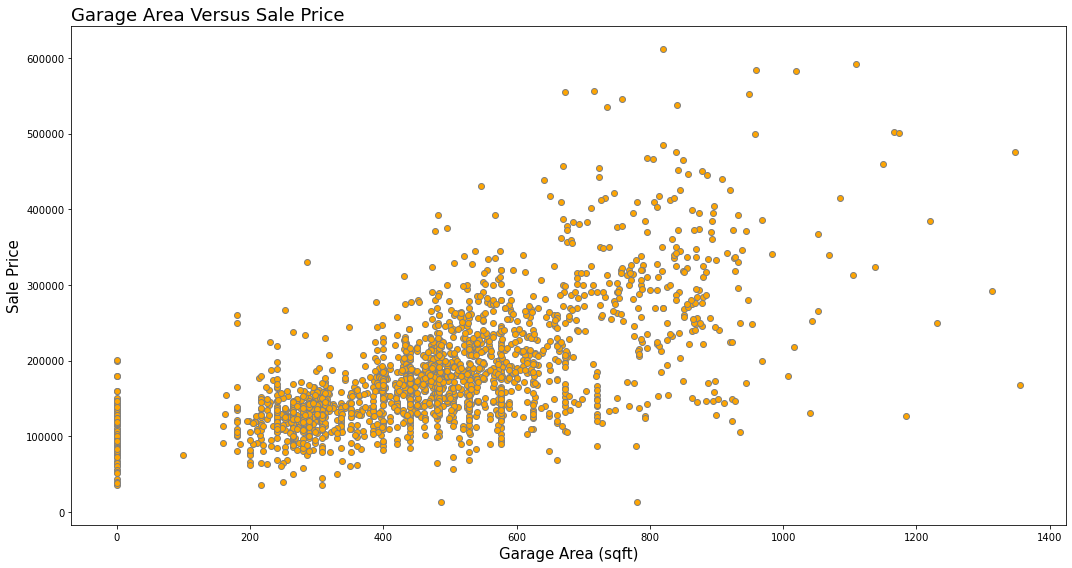

In [69]:
plt.figure(figsize = (15, 8))
plt.scatter(x = df_train['Garage Area'], y = df_train['SalePrice'], color = 'orange', edgecolor = 'gray')
plt.xlabel('Garage Area (sqft)', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Garage Area Versus Sale Price', fontsize = 18, loc = 'left')
plt.tight_layout()
plt.savefig("../images/garea_sp.png", dpi=100);

**Findings:**
> * Houses with larger garage area can be sold at a higher price.
> * Some houses have no garage, and they sold at a lower range of price.

#### Selected feature 8: `Full Bath` (Full bathrooms above grade)

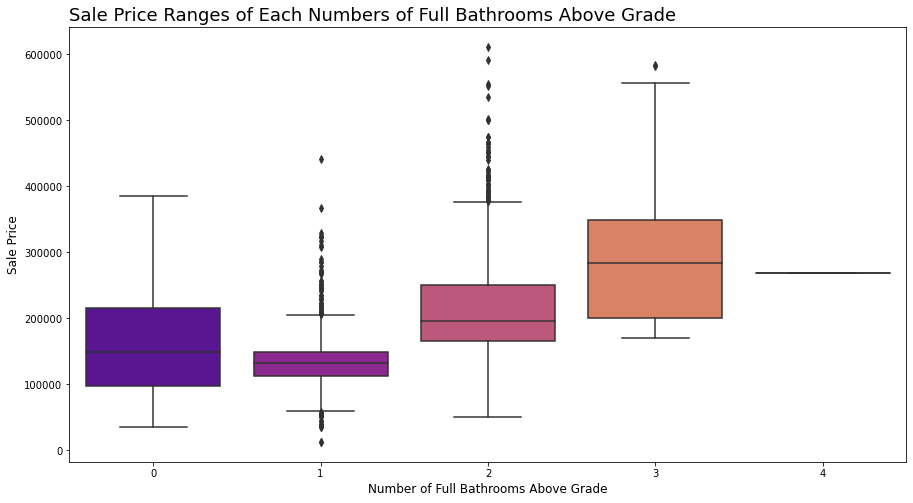

In [25]:
plt.figure(figsize = (15, 8))
sns.boxplot(x = 'Full Bath', y = 'SalePrice', data = df_train, palette = 'plasma')
plt.xlabel('Number of Full Bathrooms Above Grade', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Sale Price Ranges of Each Numbers of Full Bathrooms Above Grade', fontsize = 18, loc = 'left');

**Findings:**
> * Houses with 3 full bathrooms above grade can be sold in a higher range of price.

### Create New Features
**1. Year-related**
>The original year features - `Year Built`, `Year Remod/Add`, Year Sold(`Yr Sold`), Garage Year Built (`Garage Yr Built`)

#### Create a new feature:
* `Remod` (If the house has been remodeled or not.)

In [26]:
df_train['Remod'] = np.where(df_train['Year Remod/Add'] == df_train['Year Built'], 0, 1)
df_test['Remod'] = np.where(df_test['Year Remod/Add'] == df_test['Year Built'], 0, 1)
new_col.append('Remod')

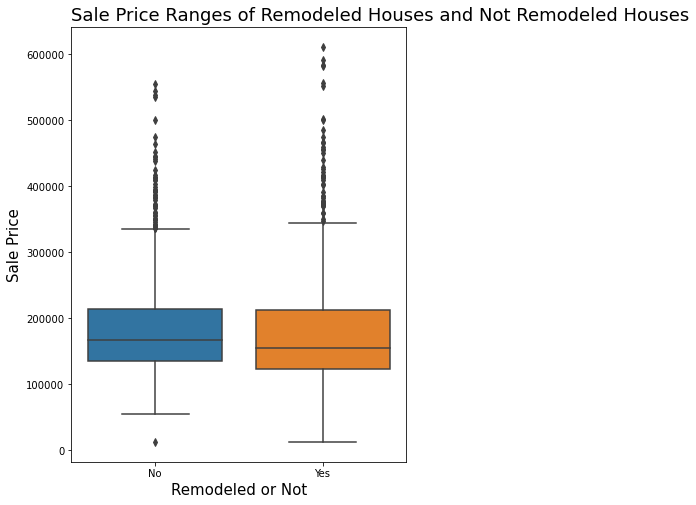

In [27]:
plt.figure(figsize = (6, 8))
sns.boxplot(x = 'Remod', y = 'SalePrice', data = df_train)
plt.xticks([0, 1], ['No', 'Yes'])
plt.xlabel('Remodeled or Not', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Sale Price Ranges of Remodeled Houses and Not Remodeled Houses', fontsize = 18, loc = 'left');

**Findings:**
> * Whether the houses have been remodeled or not has not significant impact on its sales price.

#### Create a new feature:
* `new_garage` (Whether the garage was built on the year sold)

In [28]:
df_train['new_garage'] = np.where(df_train['Yr Sold'] == df_train['Garage Yr Blt'], 1, 0)
df_test['new_garage'] = np.where(df_test['Yr Sold'] == df_test['Garage Yr Blt'], 1, 0)
new_col.append('new_garage')

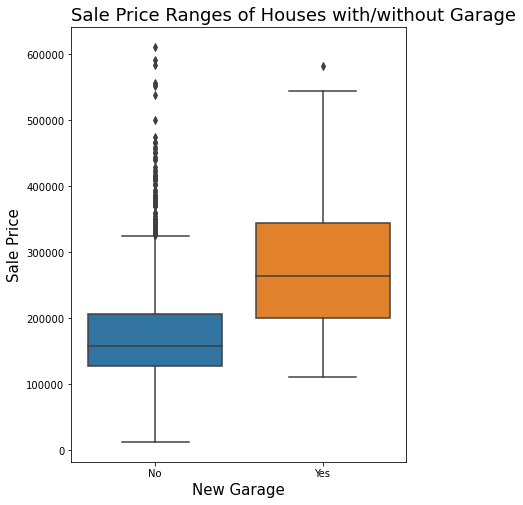

In [29]:
plt.figure(figsize = (6, 8))
sns.boxplot(x = 'new_garage', y = 'SalePrice', data = df_train)
plt.xlabel('New Garage', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.xticks([0, 1], ['No', 'Yes'])
plt.title('Sale Price Ranges of Houses with/without Garage', fontsize = 18, loc = 'left');

**Findings:**
> * Houses with garage have a higher average sale price than houses that have no garage.

#### Create a new feature:
* `new_house` (Whether the house was built on the year sold)

In [30]:
df_train['new_house'] = np.where(df_train['Yr Sold'] == df_train['Year Built'], 1, 0)
df_test['new_house'] = np.where(df_test['Yr Sold'] == df_test['Year Built'], 1, 0)
new_col.append('new_house')

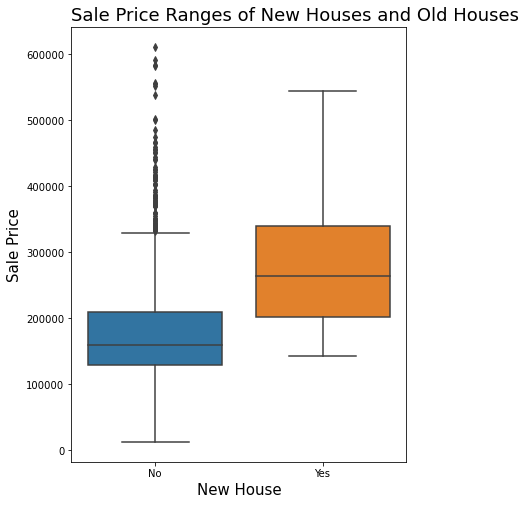

In [31]:
plt.figure(figsize = (6, 8))
sns.boxplot(x = 'new_house', y = 'SalePrice', data = df_train)
plt.xlabel('New House', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.xticks([0, 1], ['No', 'Yes'])
plt.title('Sale Price Ranges of New Houses and Old Houses', fontsize = 18, loc = 'left');

**Findings:**
> * New houses (houses sold at the same year it was built) have a higher average sale price than old houses.

**2. Summary Columns**
#### Create a new feature:
* `total_sqft` = The total area of the basement, 1st floor, and 2nd floor in sqft.

In [32]:
# Total Area
df_train['total_sqft'] = df_train['Total Bsmt SF'] + df_train['1st Flr SF'] + df_train['2nd Flr SF']
df_test['total_sqft'] = df_test['Total Bsmt SF'] + df_test['1st Flr SF'] + df_test['2nd Flr SF']
new_col.append('total_sqft')

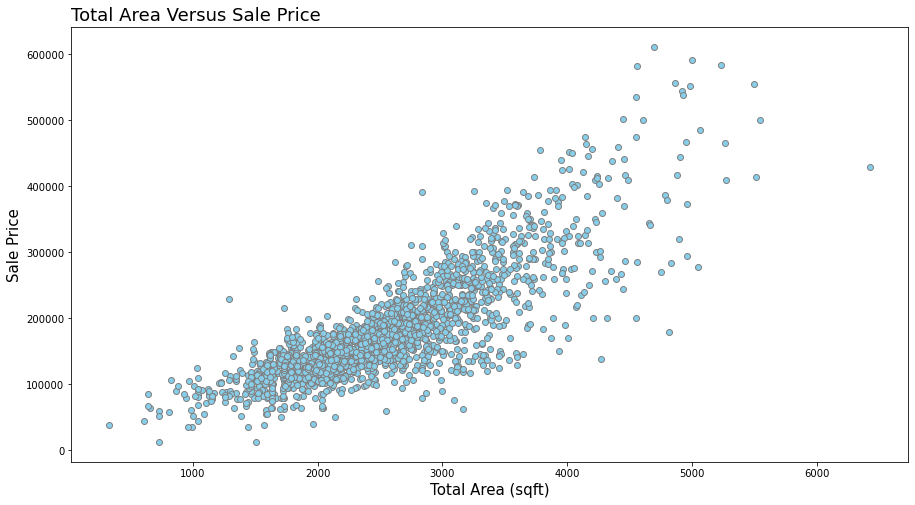

In [33]:
plt.figure(figsize = (15, 8))
plt.scatter(x = df_train['total_sqft'], y = df_train['SalePrice'], color = 'skyblue', edgecolor = 'gray')
plt.xlabel('Total Area (sqft)', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Total Area Versus Sale Price', fontsize = 18, loc = 'left');

#### Other findings

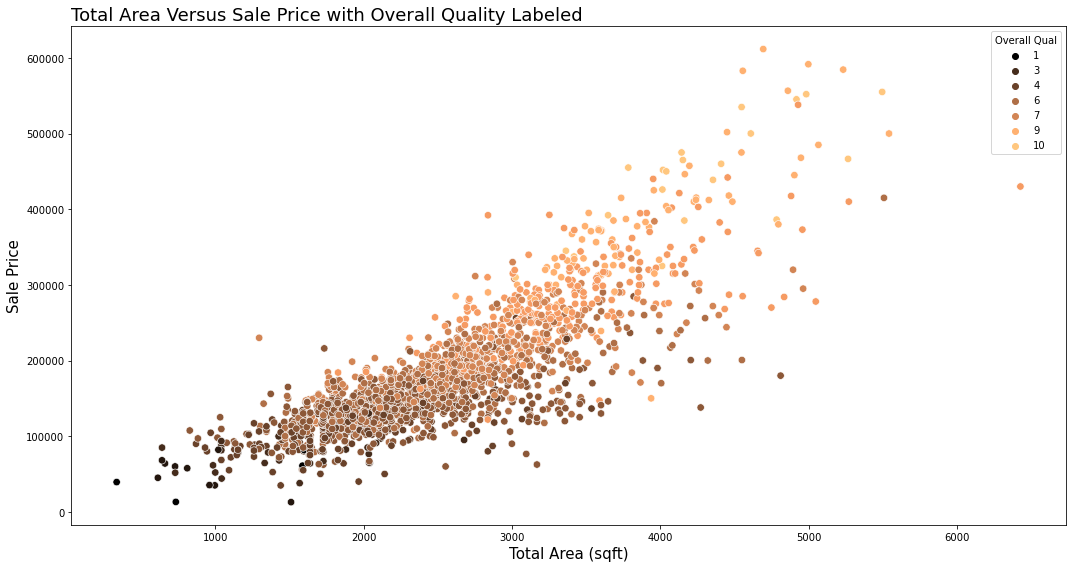

In [58]:
plt.figure(figsize = (15, 8))
sns.scatterplot(data = df_train, x = 'total_sqft', y = 'SalePrice',
                hue = 'Overall Qual', palette = 'copper', s = 55)
plt.xlabel('Total Area (sqft)', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Total Area Versus Sale Price with Overall Quality Labeled', fontsize = 18, loc = 'left')
plt.tight_layout()
plt.savefig("../images/sqft_sp_with_overallqual.png", dpi=100);

**Findings:**
> * Big houses with higher overall quality can be sold at a higher price.

#### Create new feature:
* `total_baths` = The total number of bathrooms in both the basement and above ground.

In [35]:
# Total Bathrooms
df_train['Bsmt Full Bath'] = df_train['Bsmt Full Bath'].fillna(0)
df_test['Bsmt Full Bath'] = df_test['Bsmt Full Bath'].fillna(0)
df_train['Bsmt Half Bath'] = df_train['Bsmt Half Bath'].fillna(0)
df_test['Bsmt Half Bath'] = df_test['Bsmt Half Bath'].fillna(0)

df_train['total_baths'] = df_train['Full Bath'] + df_train['Bsmt Full Bath'] + 0.5*(df_train['Half Bath'] + df_train['Bsmt Half Bath'])
df_test['total_baths'] = df_test['Full Bath'] + df_test['Bsmt Full Bath'] + 0.5*(df_test['Half Bath'] + df_test['Bsmt Half Bath'])

new_col.append('total_baths')

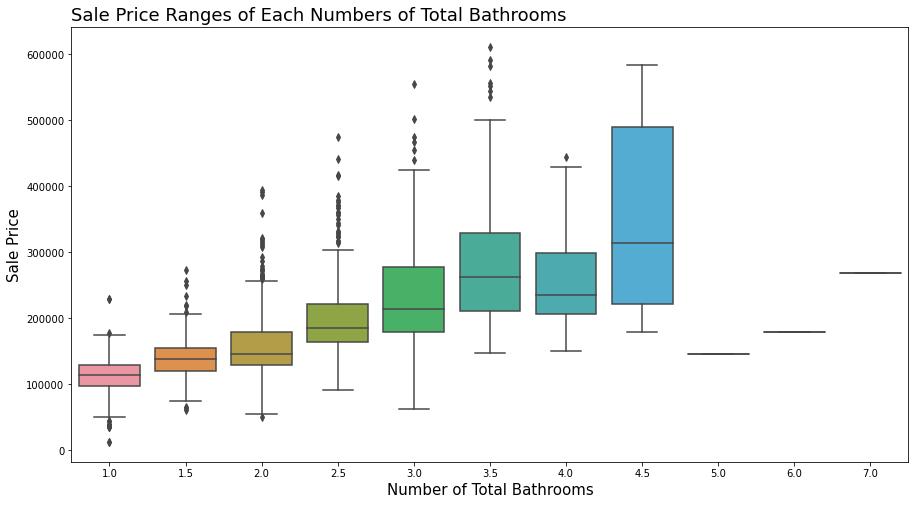

In [36]:
plt.figure(figsize = (15, 8))
sns.boxplot(x = 'total_baths', y = 'SalePrice', data = df_train)
plt.xlabel('Number of Total Bathrooms', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Sale Price Ranges of Each Numbers of Total Bathrooms', fontsize = 18, loc = 'left');

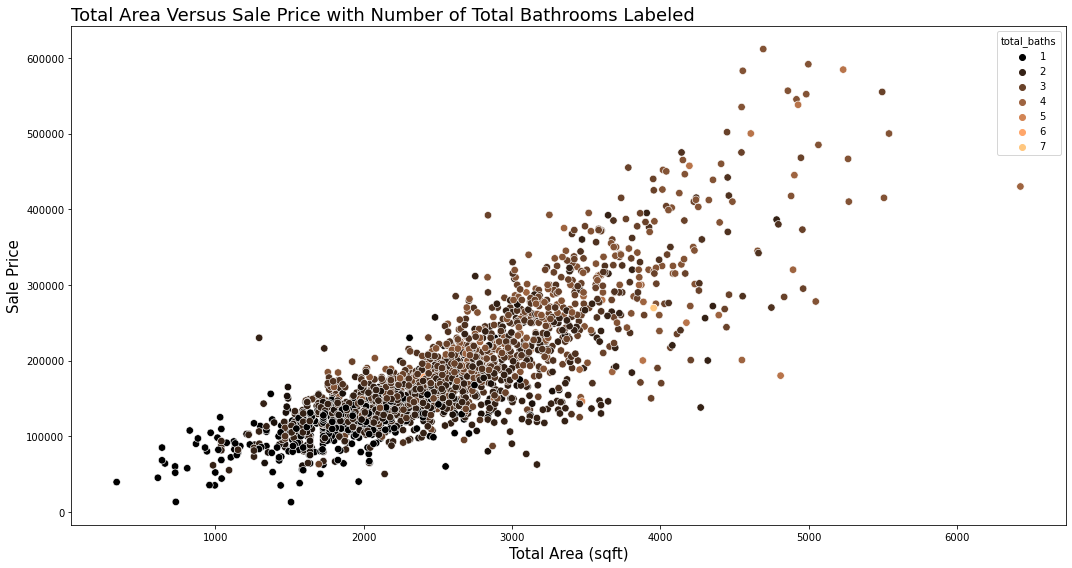

In [77]:
plt.figure(figsize = (15, 8))
sns.scatterplot(data = df_train, x = 'total_sqft', y = 'SalePrice',
                hue = 'total_baths', palette = 'copper', s = 55)
plt.xlabel('Total Area (sqft)', fontsize = 15)
plt.ylabel('Sale Price', fontsize = 15)
plt.title('Total Area Versus Sale Price with Number of Total Bathrooms Labeled', fontsize = 18, loc = 'left')
plt.tight_layout()
plt.savefig("../images/sqft_sp_with_ttbaths.png", dpi=100);

**Findings:**
> * Houses have more bathrooms can be sold at a higher price.
> * However, if the number of bathrooms is large but not the house size, the sale price is going to be lower. For example, the light spot in the second plot shows that if the house has 7 bathrooms but with only 4,000 sqft, the sale price was only around $275,000.

### Final Numerical Variables Selected

In [38]:
ly = sel_num_col + new_col
ly.append('SalePrice')

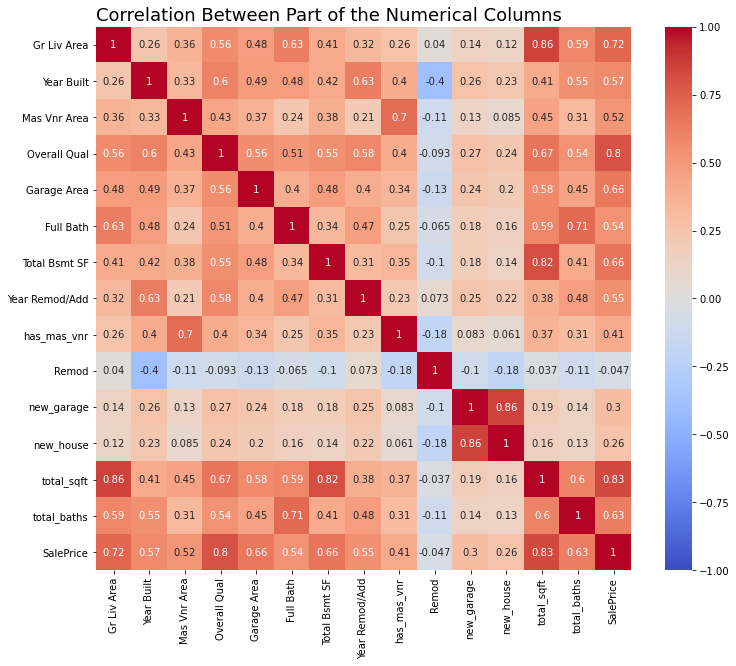

In [39]:
plt.figure(figsize = (12,10))
sns.heatmap(df_train[ly].corr(), annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.title('Correlation Between Part of the Numerical Columns', fontsize = 18, loc = 'left');

#### Remove columns with high correlation.

In [40]:
final_num_col = sel_num_col + new_col
final_num_col = set(final_num_col) - {'Total Bsmt SF', 'Gr Liv Area', 'Full Bath'}
final_num_col = list(final_num_col)

### EDA - Categorical Columns

In [41]:
def cat_var_boxplot(col_name, target_col_name):
    mean_order = df_train.groupby(col_name)[[
        target_col_name]].mean().sort_values(by = target_col_name, ascending = False).index.tolist()
    sns.boxplot(x = col_name, y = target_col_name, data = df_train, order = mean_order)
    title_name = col_name + ' Versus Sale Price'
    plt.title(title_name, loc = 'left')

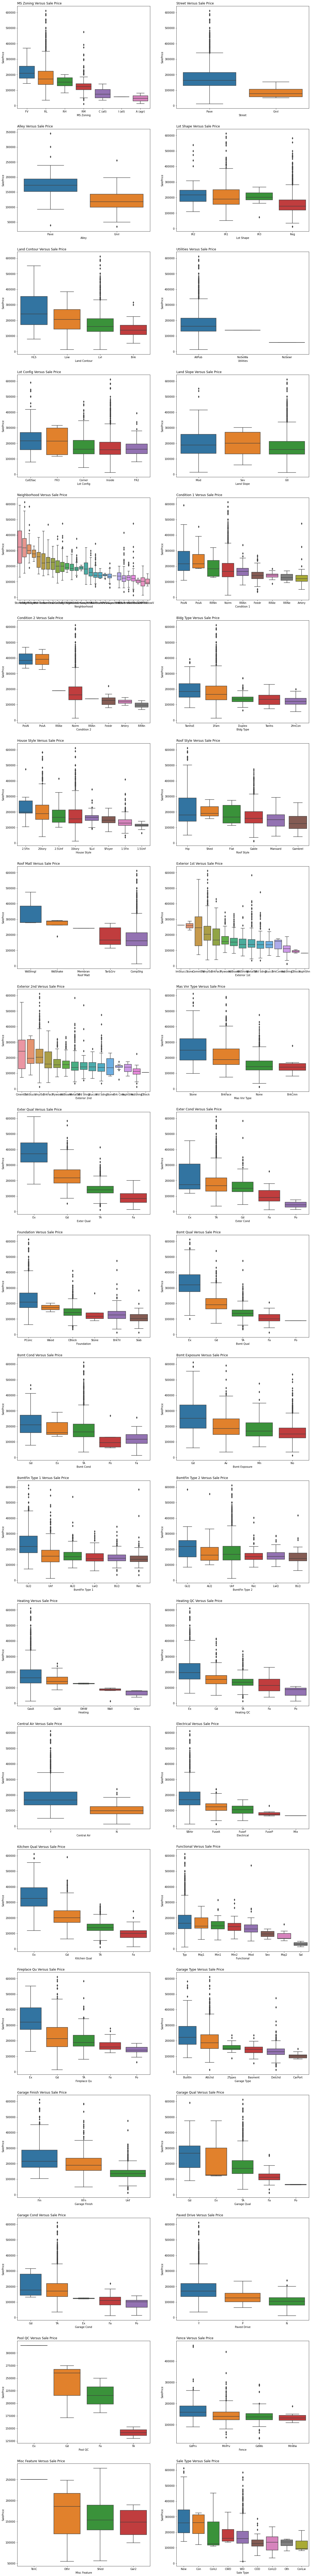

In [42]:
fig, axs = plt.subplots(int(len(cat_cols)/2), 2, sharey=True, figsize=(20, 180))

for i in range(len(cat_cols)):
    plt.subplot(int(len(cat_cols)/2), 2, i+1)
    cat_var_boxplot(cat_cols[i], 'SalePrice')

#### Other insights:
Neighborhood sale price growth pattern

In [43]:
# Top Avg. Sale Price Neighborhood (avg, over $200,000)
top_nbh = []
new_df = df_train.groupby('Neighborhood')['SalePrice'].mean().reset_index()
for i in range(len(new_df)):
    if new_df['SalePrice'][i] >= 200000:
        top_nbh.append(new_df['Neighborhood'][i])

# Groupby Neighborhood and Yr Sold to see the sale price pattern over years
grouped_df = df_train.groupby(['Neighborhood','Yr Sold']).agg({'SalePrice': ['mean']})
grouped_df.columns = ['SalePrice_mean']
grouped_df = grouped_df.reset_index()

# Select cities that have sale price records in each years from 2006 to 2010
ly = []
n_name = []
for n in top_nbh:
    a = grouped_df[grouped_df['Neighborhood'] == n]['SalePrice_mean'].tolist()
    if len(a) == 5:
        ly.append(a)
        n_name.append(n)
d = dict(zip(n_name, ly))
df = pd.DataFrame(d, index = [2006, 2007, 2008, 2009, 2010])

# Rename the city name
nbh_n = ['Bloomington Heights', 'Clear Creek', 'College Creek', 'Crawford',
       'Northridge', 'Northridge Heights', 'Somerset', 'Stone Brook', 'Timberland']

df.set_axis(nbh_n, axis = 1, inplace = True)

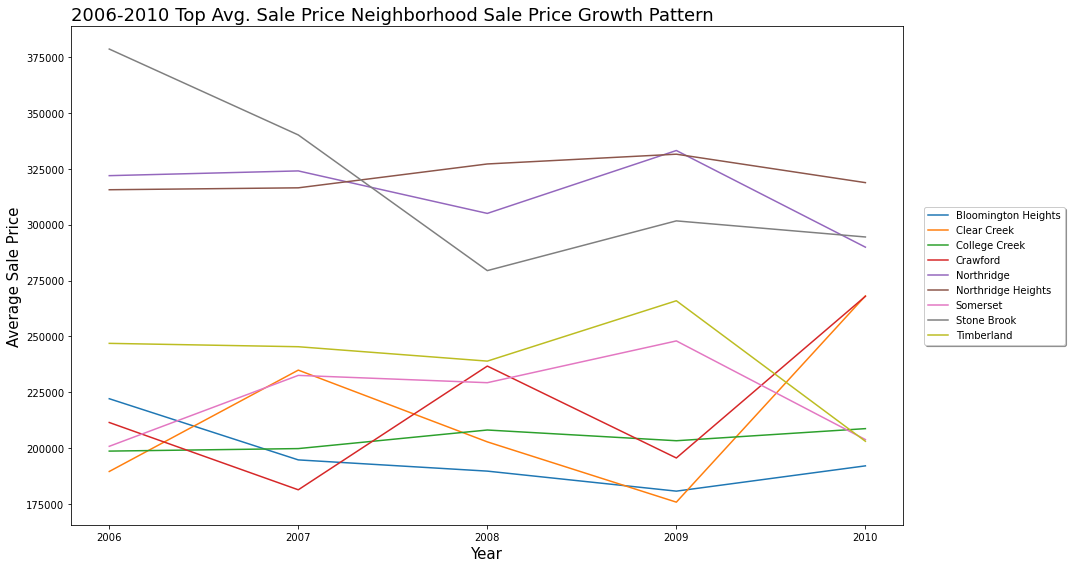

In [72]:
# Plot
df.plot(figsize = (15, 8))
plt.xticks([2006, 2007, 2008, 2009, 2010])
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Average Sale Price', fontsize = 15)
plt.title('2006-2010 Top Avg. Sale Price Neighborhood Sale Price Growth Pattern', loc = 'left', fontsize = 18)
plt.legend(loc='center right', fancybox=True, shadow=True, bbox_to_anchor=(1.2, 0.5))
plt.tight_layout()
plt.savefig("../images/Nbh_sp_growth.png", dpi=100);

**Findings:**
> * The average sale price of Neighborhoods in Ames can be mainly divided into three levels- low price (less than \\$175,000), medium price (\\$175,000 - \\$275,000), and high price (\\$275,000 - \\$350,000).
> * The above plot we only see two levels, medium and high, since I select only neighborhoods whose averarge sale price over \\$200,000. 
> * We can tell from this plot that the top 3 lines indicate the high price level neighborhood, including Northridge Heights, Northridge, and Stone Brook. The the rest are the medium level. 
> * The orange and red lines, which are represent the Clear Creek and the Crawford, growth the most recently (from 2009 to 2010). In the long term, they might be good neighborhoods for property investment.

Note: Plot label source: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot

### EDA - Target Variable: `SalePrice`

In [45]:
df_train['SalePrice'].mean()

181518.56765999022

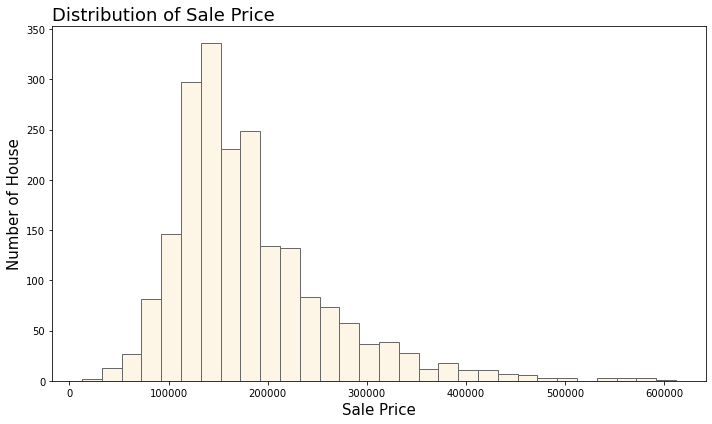

In [73]:
plt.figure(figsize = (10,6))
plt.hist(df_train['SalePrice'], bins = 30, color = 'oldlace', edgecolor = 'dimgray')
plt.xlabel('Sale Price', fontsize = 15)
plt.ylabel('Number of House', fontsize = 15)
plt.title('Distribution of Sale Price', fontsize = 18, loc = 'left')
plt.tight_layout()
plt.savefig("../images/dist_sp.png", dpi=100);

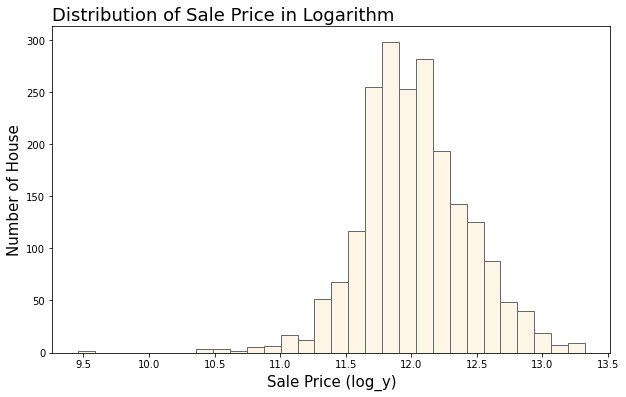

In [71]:
plt.figure(figsize = (10,6))
plt.hist(np.log(df_train['SalePrice']), bins = 30, color = 'oldlace', edgecolor = 'dimgray')
plt.xlabel('Sale Price (log_y)', fontsize = 15)
plt.ylabel('Number of House', fontsize = 15)
plt.title('Distribution of Sale Price in Logarithm', fontsize = 18, loc = 'left');

### Data Cleaning

#### Checking the missing values in numerical features

In [48]:
num_mis = pd.DataFrame(df_train[final_num_col].isnull().sum(), columns = ['num_mis'])
num_mis[num_mis['num_mis'] > 0].sort_values(by = 'num_mis', ascending = False)

,num_mis
Mas Vnr Area,22
Garage Area,1


Fill missing values in column `Mas Vnr Area` with 0.

In [49]:
df_train['Mas Vnr Area'] = df_train['Mas Vnr Area'].fillna(0)
df_test['Mas Vnr Area'] = df_test['Mas Vnr Area'].fillna(0)

Fill missing values in column `Garage Area` with the average garage area of the observations with same garage type (that is, `Garage Type` = Detchd)

In [50]:
de_mean = df_train[df_train['Garage Type'] == 'Detchd']['Garage Area'].mean()
df_train['Garage Area'] = df_train['Garage Area'].fillna(de_mean)

In [51]:
de_mean = df_test[df_test['Garage Type'] == 'Detchd']['Garage Area'].mean()
df_test['Garage Area'] = df_test['Garage Area'].fillna(de_mean)

#### Checking the missing values in categorical features

In [52]:
cat_mis = pd.DataFrame(df_train[cat_cols].isnull().mean(), columns = ['num_mis'])
cat_mis[cat_mis['num_mis'] > 0].sort_values(by = 'num_mis', ascending = False)

,num_mis
Pool QC,0.996092
Misc Feature,0.968735
Alley,0.931607
Fence,0.805081
Fireplace Qu,0.487543
Garage Finish,0.055691
Garage Qual,0.055691
Garage Cond,0.055691
Garage Type,0.055203
Bsmt Exposure,0.027846


Fill all missing values in categories features with `No`.

In [53]:
for col in cat_mis[cat_mis['num_mis'] > 0].index.tolist():
    df_train[col] = df_train[col].fillna('No')
    df_test[col] = df_test[col].fillna('No')

Find 1 missing value in test dataset, fill in with the mode.

In [54]:
df_test['Electrical'] = df_test['Electrical'].fillna('SBrkr')

#### Plot again to see if there are different patterns.

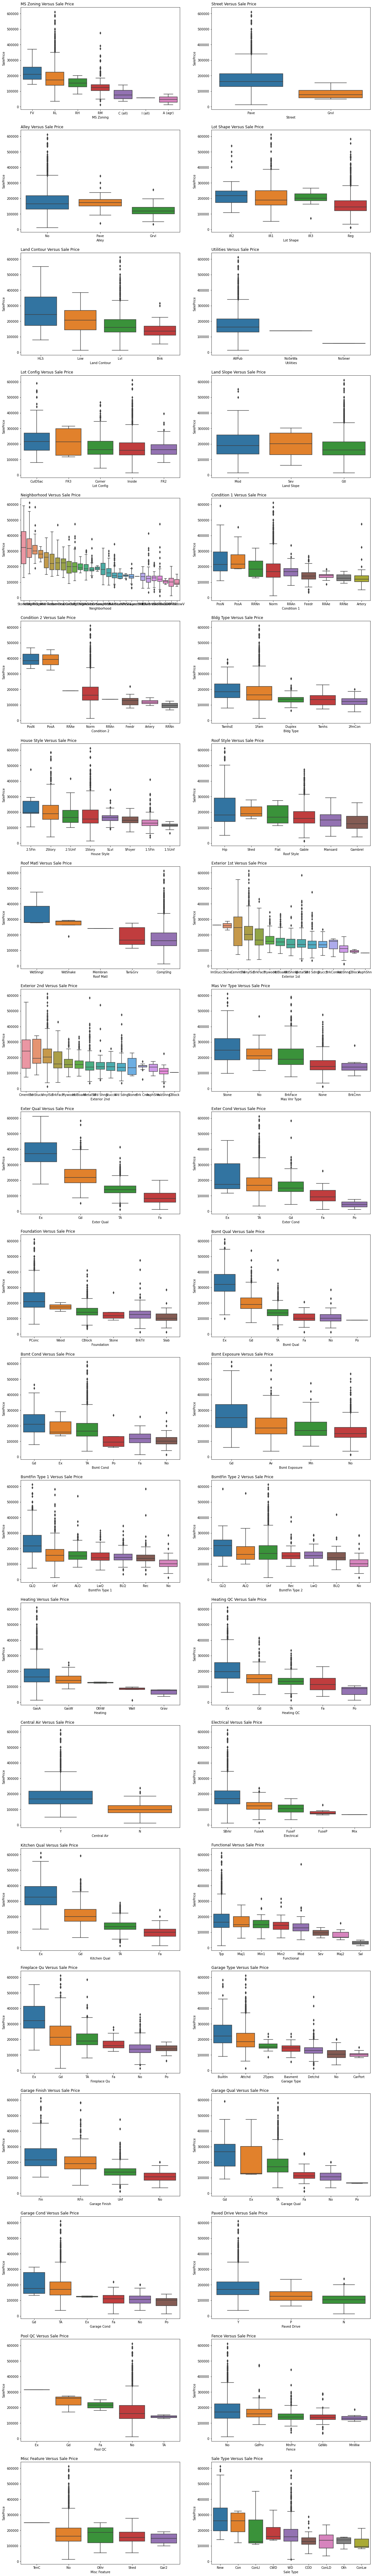

In [55]:
fig, axs = plt.subplots(int(len(cat_cols)/2), 2, sharey=True, figsize=(20, 150))

for i in range(len(cat_cols)):
    plt.subplot(int(len(cat_cols)/2), 2, i+1)
    cat_var_boxplot(cat_cols[i], 'SalePrice')

### Combine the selected numerical and categorical columns

In [56]:
final_cols = final_num_col + cat_cols
len(final_cols)

53

## Output Cleaned Data

In [57]:
df_train.to_csv('../data/train_cleaned.csv', index = False)
df_test.to_csv('../data/test_cleaned.csv', index = False)